# Porosity image classification via XCT labelling Debugging

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from os import walk
import time
import regex as re
import os
import glob
import tensorflow as tf
import warnings
import matplotlib
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [2]:
!jupyter nbconvert --output-dir="./reqs" --to script 5_Model_Training_XCT
!cd reqs
!pipreqs --print

[NbConvertApp] Converting notebook 5_Model_Training_XCT.ipynb to script
[NbConvertApp] Writing 20983 bytes to reqs\5_Model_Training_XCT.py


h5py==3.7.0
matplotlib==3.5.3
MedPy==0.4.0
numpy==1.23.2
opencv_python==4.6.0.66
pandas==1.4.3
regex==2022.8.17
scikit_image==0.19.3
scikit_learn==1.1.2
skimage==0.0
tensorflow==2.10.0
tensorflow_gpu==2.7.0


INFO: Successfully output requirements


#### GPU configuration

In [3]:
import warnings

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found")
else:
    print("Default GPU device: {}".format(tf.test.gpu_device_name()))
    
print("Num Devices Available: ", len(tf.config.experimental.list_physical_devices()))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Default GPU device: /device:GPU:0
Num Devices Available:  2
Num CPUs Available:  1
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5791335799942758592
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2907098318
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7689833157378287689
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Data Acqusition

In [4]:
def load_all_image_path(img_dir):
    
    #img_dir = "./Build2" # Enter Directory of all images
    img_labels = []
    for(_, _, filenames) in walk(img_dir):
        img_labels.extend(filenames)
        break
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    return files, img_labels
    

### Data Labels
__Layers with porosity__
> Followig are the index numbers of porosity images from three cylinders, B1, B2 & B3. The labels were based on the CAD file
information.

__Old Labels__

In [5]:
b1_prosity_index = list(range(311,380)) + list(range(537, 554)) + list(range(628, 663)) + list(range(832, 862)) + list(range(936, 937)) + list(range(940, 953)) + list(range(1011, 1078)) + list(range(1145, 1152))
b2_prosity_index = list(range(311,380)) + list(range(428, 463)) + list(range(531, 560)) + list(range(640, 654)) + list(range(737, 753))
b3_prosity_index = list(range(420,456)) + list(range(519, 546)) + list(range(619, 634)) + list(range(719, 736)) + list(range(819, 827)) + list(range(919, 923))

__New Labels__

The following image indexes were wrongly labels in CAD-assisted labelling. All these images were wrongly labelled as porosity i.e. porosity=1. We relabelled these indexes from porosity to non-porosity labels. 

In [6]:
b1_remove_index = [311,312,313,318,320,325,326,335,340,366,369,374,375,376,537,538,539,540,541,542,543,544,545,546,547,
                       548,549,550,551,552,553,628,629,630,633,640,641,642,643,646,647,648,649,650,651,653,654,656,657,659,
                      661,662,833,832,833,834,835,836,837,838,840,842,843,844,845,846,847,849,850,851,852,853,855,857,936,
                       940,947,949,950,952,1011,1011,1012,1014,1018,1019,1020,1029,1030,1045,1075,1145,1146,1147,1148,1149,
                       1150,1151]


b2_remove_index = [320,324,429,430,431,432,433,434,437,450,451,452,456,459,462,531,532,533,534,535,536,537,
                      538,539,540,541,542,544,545,548,549,550,554,559,640,641,642,643,644,645,646,647,651,737,
                      740,741,742,743,744,745,748,750,751,752]


b3_remove_index = [420,423,425,436,439,442,449,453,519,521,522,533,534,538,541,542,543,620,621,622,627,629,
                      630,631,632,721,723,724,727,728,729,733,735,819,820,821,822,826,919,920,921,922]

In [7]:
#remove the indexex from B1_porosity_index list that are present in B1-remove_index list

b1_prosity_index = [x for x in b1_prosity_index if x not in b1_remove_index]

b2_prosity_index = [x for x in b2_prosity_index if x not in b2_remove_index]

b3_prosity_index = [x for x in b3_prosity_index if x not in b3_remove_index]

### Image selection and Cropping

> The following function receives a chunk of image's path and their corresponding labels. Not all the images in Build2 are relevant to our cylinders. Out of total 2922 images, only 963 images relevant to our 3d objects. Three cylinders names as B1, B2, B3 were printed. Images from 243 to 1243 are related to B1 and B2 cylinders. Whereas, B3 cylinder related images are ranges from 218 to 1218. 
<br><br><br>
Firstly, the images were read into a numpy array. The image dimensions are __height = 2600 and Width = 1420__. Each image is then cropped into three small sections. __Height=1250-1440 and width=650-1100__ is firstly croped from the whole powder bed image.  <br> <br>
The cropped image is further is divided into three parts, each containg the image of a cylinder[B1,B2,B3]. The coordinates of __B1=[h:0-190, w:0-150]__, __B2 = [h:0-190, w:150-300]__ , __B3 = [h:0-190, w:300-450]__. The three images were then stored in different folders on the hard-drive.  
> The __crop_save_images__ function read images from hard drive and crop out B1, B2, and B3 cylinders into individual images. It also labels the images. The label consisted of 
__label = Porosity_flag +  cylinder name + layer number__ 

In [9]:
def crop_save_images(files, directory, labels):
    
    for f1,lab in zip(files,labels):
        #F1 = File path.
        #lab = Image label
        #print("F1: " + str(f1))
        #print("Lab: " +  str(lab))
        ########## read image
        orig_img = cv2.imread(f1)

        ########### crop image
        img = orig_img[1250:1440, 650:1100]
        img1 = img[0:190,0:150]
        img2 = img[0:190,150:300]
        img3 = img[0:190,300:450]

        ########### Label Image
        
        tt = lab[:-4].split('_')
        #tt = layer number
        #print(tt[3])
        layer_no = int(tt[3])
        #########################################################################################-----B1
        if (layer_no in b1_prosity_index):
            ############################################################### 2mm
            if(layer_no >= 314 and layer_no <=379) or (layer_no >= 1013 and layer_no <=1077):
                img_name_b1 = "1_B1_Layer_"+str(layer_no)+"_2mm"+".jpg"
            ############################################################### 1mm
            elif (layer_no >= 631 and layer_no <=660) or (layer_no >= 839 and layer_no <=861):
                img_name_b1 = "1_B1_Layer_"+str(layer_no)+"_1mm"+".jpg"
            ############################################################### 0.5mm
            elif (layer_no >= 941 and layer_no <=951):
                img_name_b1 = "1_B1_Layer_"+str(layer_no)+"_05mm"+".jpg"
        else:
            img_name_b1 = "0_B1_Layer_"+str(layer_no)+".jpg"
            #print("False")
        #########################################################################################-----B2
        if (layer_no in b2_prosity_index):
            ############################################################### 2mm
            if(layer_no >= 311 and layer_no <=379):
                img_name_b2 = "1_B2_Layer_"+str(layer_no)+"_2mm"+".jpg"
            ############################################################### 1mm
            elif (layer_no >= 428 and layer_no <=461):
                img_name_b2 = "1_B2_Layer_"+str(layer_no)+"_1mm"+".jpg"
            ############################################################### 0.8mm
            elif (layer_no >= 543 and layer_no <=558):
                img_name_b2 = "1_B2_Layer_"+str(layer_no)+"_08mm"+".jpg"
            ############################################################### 0.5mm
            elif (layer_no >= 648 and layer_no <=653):
                img_name_b2 = "1_B2_Layer_"+str(layer_no)+"_05mm"+".jpg"
            ############################################################### 0.4mm
            elif (layer_no >= 738 and layer_no <=749):
                img_name_b2 = "1_B2_Layer_"+str(layer_no)+"_04mm"+".jpg"
            
        else:
            img_name_b2 = "0_B2_Layer_"+str(layer_no)+".jpg"
            #print("False")
        #########################################################################################-----B3
        if (layer_no in b3_prosity_index):
            ############################################################### 1mm
            if(layer_no >= 421 and layer_no <=455):
                img_name_b3 = "1_B3_Layer_"+str(layer_no)+"_1mm"+".jpg"
            ############################################################### 0.8mm
            elif (layer_no >= 520 and layer_no <=545):
                img_name_b3 = "1_B3_Layer_"+str(layer_no)+"_08mm"+".jpg"
            ############################################################### 0.5mm
            elif (layer_no >= 619 and layer_no <=633):
                img_name_b3 = "1_B3_Layer_"+str(layer_no)+"_05mm"+".jpg"
            ############################################################### 0.4mm
            elif (layer_no >= 719 and layer_no <=734):
                img_name_b3 = "1_B3_Layer_"+str(layer_no)+"_04mm"+".jpg"
            ############################################################### 0.2mm
            elif (layer_no >= 823 and layer_no <=825):
                img_name_b3 = "1_B3_Layer_"+str(layer_no)+"_02mm"+".jpg"
            #print(layer_no)
            #print("True")
        else:
            img_name_b3 = "0_B3_Layer_"+str(layer_no)+".jpg"
            #print("False")
        ########### store image
        if(layer_no>243 and layer_no<1243):
            img_name = directory[0] + img_name_b1
            matplotlib.image.imsave(img_name, img1)
        
            img_name = directory[1] + img_name_b2
            matplotlib.image.imsave(img_name, img2)
        if(layer_no>218 and layer_no<1218):
            img_name = directory[2] + img_name_b3
            matplotlib.image.imsave(img_name, img3)
        #break


In [10]:
# Load all image paths
img_dir_paths, img_names = load_all_image_path("D:/UoH_PhD_Exp/Data/Build2")

In [11]:
def var_info(var):
    print(type(var))
    print(len(var))
var_info(img_dir_paths)
var_info(img_names)

<class 'list'>
2922
<class 'list'>
2922


In [12]:
# Make directories to store crop images if the the directories don't exsists already
directories = ["D:/UoH_PhD_Exp/Data/Crop_images/B1/", "D:/UoH_PhD_Exp/Data/Crop_images/B2/", "D:/UoH_PhD_Exp/Data/Crop_images/B3/"]
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

#### Remove all the old files in B1, B2 & B3 folder
> Since we will be cropping images many times depedning upon the task at hand. Therefore, it is necessary to delete the old cropped images before saving the new cropped images. The following code empty the directories.

In [13]:
for directory in directories:
    files = glob.glob(os.path.join(directory,"*"))
    for f in files:
        os.remove(f)

>Since out of all the images the first 1250 layers/images are relevant to our builts. That's why only the first 1250 are considered. For B1, B2, and B3, the effective printing layers are 217-1206. For simplicity, uniformity and avoiding complexity, the relevant 1250 layers are selected.

In [14]:
#cropping images
crop_save_images(img_dir_paths[217:1206] ,directories, img_names[217:1206]) 

### B1 Cylinder images

In [15]:
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B1/")
#print(labels[0])
#print(files[0])
data = []
b1_labels = list()
b1_layer_numbers = list()
for f1, lab in zip(files, labels):
    #print("lab:" + lab)
    layer_num = re.search('Layer_(.+?).jpg', lab).group(1)
    b1_layer_numbers.append("b1_"+str(layer_num))
    b1_labels.append(int(lab[0]))
    img = cv2.imread(f1)
    ######### Convert to Images to grey scale.
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(img)
b1_images = np.array(data)
print("B1 image shape: ", b1_images[0].shape)
#print(b1_labels[0])
#print(b1_layer_numbers[0])
print("B1 images dataset shape: ",b1_images.shape)
(unique, counts) = np.unique(b1_labels, return_counts=True)
print(unique, counts)
print("Total non-porosity images in B1: ", counts[0])
print("Total porosity images in B1: ", counts[1])

B1 image shape:  (190, 150, 3)
B1 images dataset shape:  (963, 190, 150, 3)
[0 1] [826 137]
Total non-porosity images in B1:  826
Total porosity images in B1:  137


### B2 Cylinder images

In [16]:
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B2/")
data = []
b2_labels = list()
b2_layer_numbers = list()
for f1, lab in zip(files, labels):
    layer_num = re.search('Layer_(.+?).jpg', lab).group(1)
    b2_layer_numbers.append("b2_"+str(layer_num))
    img = cv2.imread(f1)
    b2_labels.append(int(lab[0]))
    ######## Convert to Images to grey scale.
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(img)
b2_images = np.array(data)
print("B2 image shape: ", b2_images[0].shape)
#print(b2_labels[0])
#print(b2_layer_numbers[0])
print("B2 images dataset shape: ",b2_images.shape)
(unique, counts) = np.unique(b2_labels, return_counts=True)
print(unique, counts)
print("Total non-porosity images in B2: ", counts[0])
print("Total porosity images in B2: ", counts[1])

B2 image shape:  (190, 150, 3)
B2 images dataset shape:  (963, 190, 150, 3)
[0 1] [854 109]
Total non-porosity images in B2:  854
Total porosity images in B2:  109


### B3 Cylinder images

In [17]:
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B3")
data = []
b3_labels = list()
b3_layer_numbers = list()
for f1, lab in zip(files, labels):
    layer_num = re.search('Layer_(.+?).jpg', lab).group(1)
    b3_layer_numbers.append("b3_"+str(layer_num))
    img = cv2.imread(f1)
    b3_labels.append(int(lab[0]))
    ######## Convert to Images to grey scale.
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(img)
b3_images = np.array(data)
print("B1 image shape: ", b3_images[0].shape)
#print(b3_labels[0])
#print(b3_layer_numbers[0])
print("B3 images dataset shape: ",b3_images.shape)
(unique, counts) = np.unique(b3_labels, return_counts=True)
print(unique, counts)
print("Total non-porosity images in B3: ", counts[0])
print("Total porosity images in B3: ", counts[1])

B1 image shape:  (190, 150, 3)
B3 images dataset shape:  (963, 190, 150, 3)
[0 1] [898  65]
Total non-porosity images in B3:  898
Total porosity images in B3:  65


# 2. Data Pre-Processing

__Ostu Binarisation__

In [18]:
def ostu_thd(XX):
    rnd_images = []
    for img in XX:
        #img = cv2.rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Otsu's thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        rnd_images.append(th2)
    test_images = np.array(rnd_images)
    
    return test_images

__PreProcessing__

In [19]:
def pre_process(X, y, indeces):
    
    # Split the images and labels using stratified to ensure same class distribution with 70/30 train test split.
    X_train, X_test, y_train, y_test, X_indeces, y_indeces = train_test_split(X, y,indeces, test_size=0.3, random_state=786, stratify=y) 
    print("Total training intences: " + str(len(y_train)))
    print("Train Data:" + str(np.unique(y_train, return_counts=True)))
    print("Total testing intences: " + str(len(y_test)))
    print("Test Data:" + str(np.unique(y_test, return_counts=True)))

    print("\n\nBefore Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 190, 150, 1))
    X_test = X_test.reshape((X_test.shape[0], 190, 150, 1))
    print("After Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    
    # Convert the array to float32 as opposed to uint8
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    X_train /= 255
    X_test /=  255

    NUM_DIGITS = 2

    print("Before label conversion to categorical: ", y_train[0:5]) # The format of the labels before conversion

    y_train  = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

    print("After label conversion to categorical: ", y_train[0:5]) # The format of the labels after conversion

    y_test = tf.keras.utils.to_categorical(y_test, NUM_DIGITS)
    
    return X_train, X_test, y_train, y_test, X_indeces, y_indeces

__Visualising randome 12 images from the dataset__

In [20]:
def visualize_n_imgs(PBI_data,labels, n):
    
    rnd_indx = np.random.choice(PBI_data.shape[0], n, replace=False)
    print(rnd_indx)
    data = []
    titles = []
    for i in range(0,n):
        index = rnd_indx[i]
        titles.append(labels[index])
        img = PBI_data[index]#:,:,:]
        data.append(img)
    test_images = np.array(data)

    plt.figure(figsize=(16,8))
    for i in range(n):
        plt.subplot(int(n/4),4,i+1),plt.imshow(test_images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()
    


__Models Curves__

In [21]:
def loss_accuracy_curves(history):
    ############### printing accuracy and loss between the epoches #########
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label ="Validation")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label ="Validation")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [22]:
# Indeces for mode testing at later stages to find the wrong images
indeces = np.arange(0,2889,1)
# concatetinating data
X = np.concatenate((b1_images, b2_images, b3_images), axis=0)
y = b1_labels + b2_labels + b3_labels
layer_nums = b1_layer_numbers + b2_layer_numbers + b3_layer_numbers

print("Total images dataset(X) before Otsu thresholding: " + str(X.shape))
print("Total labels (y): " + str(len(y)))
(unique, counts) = np.unique(y, return_counts=True)
print(unique, counts)
print("Total non-porosity images in final concatenanted dataset: ", counts[0])
print("Total porosity images in final concatenanted dataset: ", counts[1])
X = ostu_thd(X)
print("Total images dataset(X) after Otsu thresholding: " + str(X.shape) + "\n")
X_train, X_test, y_train, y_test,X_indeces, y_indeces = pre_process(X,y, indeces)

Total images dataset(X) before Otsu thresholding: (2889, 190, 150, 3)
Total labels (y): 2889
[0 1] [2578  311]
Total non-porosity images in final concatenanted dataset:  2578
Total porosity images in final concatenanted dataset:  311
Total images dataset(X) after Otsu thresholding: (2889, 190, 150)

Total training intences: 2022
Train Data:(array([0, 1]), array([1804,  218], dtype=int64))
Total testing intences: 867
Test Data:(array([0, 1]), array([774,  93], dtype=int64))


Before Reshaping the shape of train and test dataset:
(2022, 190, 150)
(867, 190, 150)
After Reshaping the shape of train and test dataset:
(2022, 190, 150, 1)
(867, 190, 150, 1)
Before label conversion to categorical:  [0, 0, 0, 0, 0]
After label conversion to categorical:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# 3. Model
__Model Definition__

In [23]:
np.random.seed(786)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(190, 150,1)))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(28500,)))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(10, activation='softmax'))



model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

# We will now compile and print out a summary of our model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 150, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 71, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 35, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 75600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9676928   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

__Class Weight__  

In [24]:
weight_for_0 = 0.3
weight_for_1 = 0.7
my_class_weight = {0: weight_for_0, 1: weight_for_1}


__Model Training__

In [25]:
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=20,verbose=1, class_weight=my_class_weight)#, batch_size=250, verbose=1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
45/45 [==============================] - 7s 96ms/step - loss: 0.3634 - accuracy: 0.8756 - val_loss: 0.7110 - val_accuracy: 0.6755
Epoch 2/20
45/45 [==============================] - 3s 77ms/step - loss: 0.0812 - accuracy: 0.9484 - val_loss: 0.1213 - val_accuracy: 0.9671
Epoch 3/20
45/45 [==============================] - 4s 79ms/step - loss: 0.0511 - accuracy: 0.9717 - val_loss: 0.1338 - val_accuracy: 0.9605
Epoch 4/20
45/45 [==============================] - 4s 80ms/step - loss: 0.0424 - accuracy: 0.9611 - val_loss: 0.1398 - val_accuracy: 0.9621
Epoch 5/20
45/45 [==============================] - 3s 78ms/step - loss: 0.0196 - accuracy: 0.9880 - val_loss: 0.1306 - val_accuracy: 0.9654
Epoch 6/20
45/45 [==============================] - 4s 79ms/step - loss: 0.0519 - accuracy: 0.9717 - val_loss: 0.1441 - val_accuracy: 0.9687
Epoch 7/20
45/45

__Model Testing__

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy))

28/28 [==============================] - 1s 25ms/step - loss: 0.3915 - accuracy: 0.9689
Test accuracy: 0.97


__Model Evaluation__

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       774
           1       0.84      0.87      0.86        93

    accuracy                           0.97       867
   macro avg       0.91      0.93      0.92       867
weighted avg       0.97      0.97      0.97       867

[[759  15]
 [ 12  81]]
0.9688581314878892
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


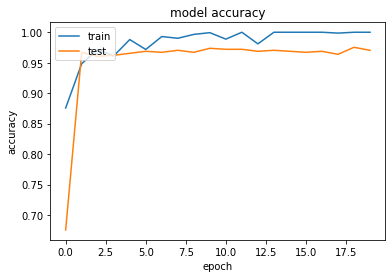

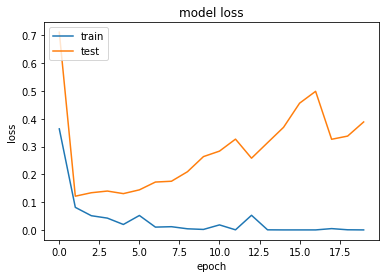

In [27]:
#### testing model on unseen test images
y_pred = model.predict(X_test)
#Convert class attribute back to its origional form, 0,1 from categorical [1. 0., 0. 1.]
y_actual = np.argmax(y_test,axis=1)
print(y_actual[0:25])
y_pred = np.argmax(y_pred,axis=1)
print(y_pred[0:25])

#Accuracy of the model on test dataset 
print(classification_report(y_actual,y_pred))
print(confusion_matrix(y_actual,y_pred))
print(accuracy_score(y_actual,y_pred))
#Models training and testing curves
loss_accuracy_curves(history)

# 4. Model Debugging

>Find out the images wrongly classified. we will find out their indexes by comparing actual and predicte labels.
The indexs will be used to print the images in the later stage.

In [28]:
j = 0
# Output list intialisation 
wrongClassiified_indexes = []
CorrectClassiified_indexes = []
# Using iteration to find 
for i in y_actual: 
    if i != y_pred[j]: 
        wrongClassiified_indexes.append(j) 
    else:
        CorrectClassiified_indexes.append(j)
    j = j + 1
    
#print(wrongClassiified_indexes)
print("Total Wrong Imgaes: " + str(len(wrongClassiified_indexes)))
#print(CorrectClassiified_indexes)
print("Total Correct Imgaes: " + str(len(CorrectClassiified_indexes)))

Total Wrong Imgaes: 27
Total Correct Imgaes: 840


In [29]:
# Printing the predicted and actual labels of the wrong predicted images along with the image name
print("Prd      Act      Image name\n")
for i in range(0, len(wrongClassiified_indexes)):
    index = wrongClassiified_indexes[i]
    print("Prd: " + str(y_pred[index]) + "   Act:" + str(y_actual[index]) + "   Layer: " + str(layer_nums[y_indeces[index]]))

Prd      Act      Image name

Prd: 0   Act:1   Layer: b3_731_04mm
Prd: 1   Act:0   Layer: b1_1186
Prd: 0   Act:1   Layer: b2_314_2mm
Prd: 0   Act:1   Layer: b2_653_05mm
Prd: 1   Act:0   Layer: b2_471
Prd: 1   Act:0   Layer: b3_893
Prd: 0   Act:1   Layer: b3_624_05mm
Prd: 0   Act:1   Layer: b3_527_08mm
Prd: 1   Act:0   Layer: b3_348
Prd: 1   Act:0   Layer: b2_1240
Prd: 1   Act:0   Layer: b2_483
Prd: 1   Act:0   Layer: b2_288
Prd: 0   Act:1   Layer: b3_447_1mm
Prd: 0   Act:1   Layer: b1_946_05mm
Prd: 1   Act:0   Layer: b3_419
Prd: 0   Act:1   Layer: b3_823_02mm
Prd: 1   Act:0   Layer: b3_1113
Prd: 1   Act:0   Layer: b3_845
Prd: 1   Act:0   Layer: b3_1145
Prd: 1   Act:0   Layer: b1_832
Prd: 0   Act:1   Layer: b3_722_04mm
Prd: 1   Act:0   Layer: b2_853
Prd: 0   Act:1   Layer: b2_443_1mm
Prd: 0   Act:1   Layer: b2_461_1mm
Prd: 1   Act:0   Layer: b1_1094
Prd: 0   Act:1   Layer: b1_1052_2mm
Prd: 1   Act:0   Layer: b2_538


__Rescalling back to three dimentions for visualization__

In [30]:
# reshape to be [samples][width][height][channels]
temp_X_train = X_train.reshape((X_train.shape[0], 190, 150))
temp_X_test = X_test.reshape((X_test.shape[0], 190, 150))

### 4.1 Wrongly classified Images
> Randomly visualised 16 wrong predicted images along with the actual and predicted labels.

[354 572 293 427 250  58 743 685 206 533 321 518 788 628 823 370]


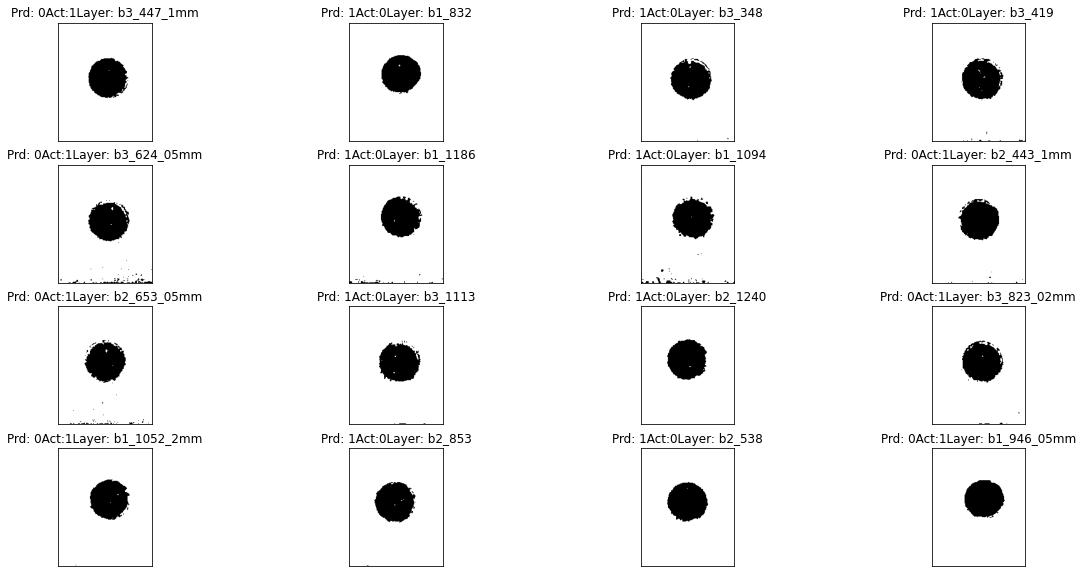

In [31]:
n = 16
rnd_indx = np.random.choice(wrongClassiified_indexes, n, replace=False)
print(rnd_indx)
data = []
titles = []
#hardcode_index = [438,1092,624,6,74,1077,270,726,151,273,80,450,609,1085,290,23]
for i in range(0,n):
    index = rnd_indx[i]
    #index = hardcode_index[i]
    titles.append("Prd: " + str(y_pred[index]) + "Act:" + str(y_actual[index]) + "Layer: " + str(layer_nums[y_indeces[index]]))
    img = temp_X_test[index]#:,:,:]
    data.append(img)
test_images = np.array(data)

plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(int(n/4),4,i+1),plt.imshow(test_images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

### 4.2 Correct Classified Images
> Randomly visualised 16 Correct predicted images along with the actual and predicted labels.

[511  25 127 711 561 589 126 411 138 259  55 576 732 410 821 725]


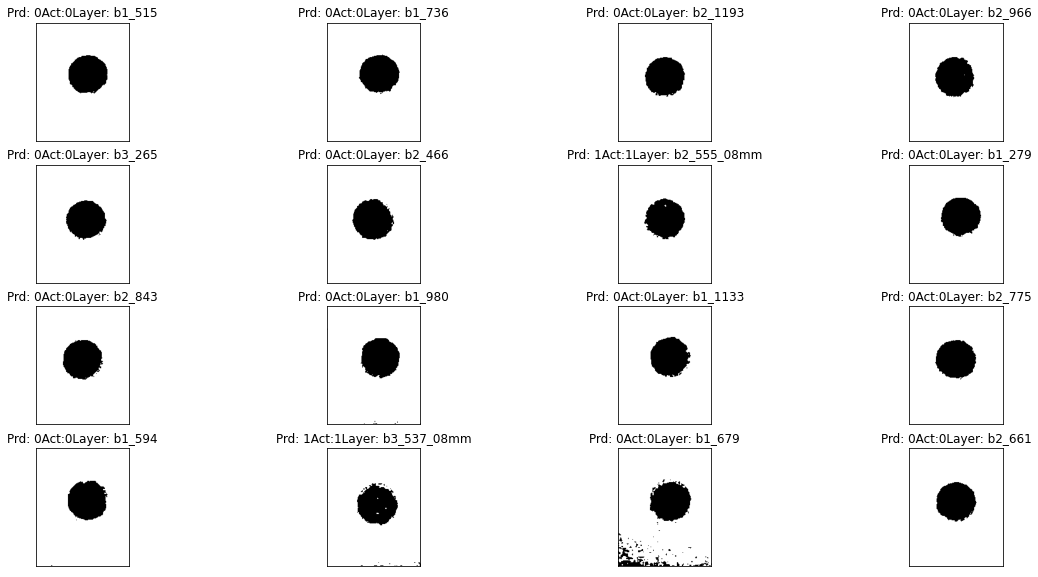

In [32]:
rnd_indx = np.random.choice(CorrectClassiified_indexes, n, replace=False)
print(rnd_indx)
n = 16
data = []
titles = []
#hardcode_index = [282,824,300,864,717,995,248,29,151,273,80,450,609,1085,290,23]
for i in range(0,n):
    index = rnd_indx[i]
    #index = hardcode_index[i]
    titles.append("Prd: " + str(y_pred[index]) + "Act:" + str(y_actual[index]) + "Layer: " + str(layer_nums[y_indeces[index]]))
    img = X_test[index]#:,:,:]
    data.append(img)
test_images = np.array(data)

plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(int(n/4),4,i+1),plt.imshow(test_images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# Model Evaluation on Different pores size

> Here we will take all the porosity images and store them on separate lists based on the size of the pore. 
Than each pore size images will be passed through the model to see how accurate the model is in predicting the specific pore sizes

In [54]:
test_set_2mm_images = []
test_set_1mm_images = []
test_set_0_8mm_images = []
test_set_0_5mm_images = []
test_set_0_4mm_images = []
test_set_0_2mm_images = []

In [55]:
## Store porosity images in different lists. 
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B1/")
for f1, lab in zip(files, labels):
    #print(lab[-8:-4])
    pore_size = lab[-8:-4]
    f1 = cv2.imread(f1)
    if(pore_size == "_2mm"):
        test_set_2mm_images.append(f1)
    elif(pore_size == "_1mm"):
        test_set_1mm_images.append(f1)
    elif(pore_size == "08mm"):
        test_set_0_8mm_images.append(f1)
    elif(pore_size == "05mm"):
        test_set_0_5mm_images.append(f1)
    elif(pore_size == "04mm"):
        test_set_0_4mm_images.append(f1)
    elif(pore_size == "02mm"):
        test_set_0_2mm_images.append(f1)
        
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B2/")
for f1, lab in zip(files, labels):
    #print(lab[-8:-4])
    pore_size = lab[-8:-4]
    f1 = cv2.imread(f1)
    if(pore_size == "_2mm"):
        test_set_2mm_images.append(f1)
    elif(pore_size == "_1mm"):
        test_set_1mm_images.append(f1)
    elif(pore_size == "08mm"):
        test_set_0_8mm_images.append(f1)
    elif(pore_size == "05mm"):
        test_set_0_5mm_images.append(f1)
    elif(pore_size == "04mm"):
        test_set_0_4mm_images.append(f1)
    elif(pore_size == "02mm"):
        test_set_0_2mm_images.append(f1)
        
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B3/")
for f1, lab in zip(files, labels):
    #print(lab[-8:-4])
    pore_size = lab[-8:-4]
    f1 = cv2.imread(f1)
    if(pore_size == "_2mm"):
        test_set_2mm_images.append(f1)
    elif(pore_size == "_1mm"):
        test_set_1mm_images.append(f1)
    elif(pore_size == "08mm"):
        test_set_0_8mm_images.append(f1)
    elif(pore_size == "05mm"):
        test_set_0_5mm_images.append(f1)
    elif(pore_size == "04mm"):
        test_set_0_4mm_images.append(f1)
    elif(pore_size == "02mm"):
        test_set_0_2mm_images.append(f1)
        
        
test_set_2mm_images = np.array(test_set_2mm_images)
test_set_1mm_images = np.array(test_set_1mm_images)
test_set_0_8mm_images = np.array(test_set_0_8mm_images)
test_set_0_5mm_images = np.array(test_set_0_5mm_images)
test_set_0_4mm_images = np.array(test_set_0_4mm_images)
test_set_0_2mm_images = np.array(test_set_0_2mm_images)


In [58]:
print("Total 2mm pore size images: ",test_set_2mm_images.shape[0])
print("Total 1mm pore size images: ", test_set_1mm_images.shape[0])
print("Total 0.8mm pore size images: ",test_set_0_8mm_images.shape[0])
print("Total 0.5mm pore size images: ",test_set_0_5mm_images.shape[0])
print("Total 0.4mm pore size images: ",test_set_0_4mm_images.shape[0])
print("Total 0.2mm pore size images: ",test_set_0_2mm_images.shape[0])

Total 2mm pore size images:  179
Total 1mm pore size images:  67
Total 0.8mm pore size images:  28
Total 0.5mm pore size images:  20
Total 0.4mm pore size images:  14
Total 0.2mm pore size images:  3


__2mm__

In [62]:
#test_set_2mm_images = ostu_thd(test_set_2mm_images)
print("X Shape after Ostu Binarisation: " + str(test_set_2mm_images.shape))
test_set_2mm_images = test_set_2mm_images.reshape((test_set_2mm_images.shape[0], 190, 150, 1))
print("X Shape after reshaping: " + str(test_set_2mm_images.shape))

y_pred = model.predict(test_set_2mm_images)

y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
#print(unique, counts)
print("\nWrong predicted images: ", counts[0])
print("Correct predicted images: ", counts[1])

X Shape after Ostu Binarisation: (179, 190, 150, 1)
X Shape after reshaping: (179, 190, 150, 1)
[0 1] [  3 176]

Wrong predicted images:  3
Correct predicted images:  176


__1mm__

In [63]:
test_set_1mm_images = ostu_thd(test_set_1mm_images)
print("X Shape after Ostu Binarisation: " + str(test_set_1mm_images.shape))
test_set_1mm_images = test_set_1mm_images.reshape((test_set_1mm_images.shape[0], 190, 150, 1))
print("X Shape after reshaping: " + str(test_set_1mm_images.shape))

y_pred = model.predict(test_set_1mm_images)

y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
#print(unique, counts)
print("\nWrong predicted images: ", counts[0])
print("Correct predicted images: ", counts[1])

X Shape after Ostu Binarisation: (67, 190, 150)
X Shape after reshaping: (67, 190, 150, 1)

Wrong predicted images:  7
Correct predicted images:  60


__0.8mm__

In [64]:
test_set_0_8mm_images = ostu_thd(test_set_0_8mm_images)
print("X Shape after Ostu Binarisation: " + str(test_set_0_8mm_images.shape))
test_set_0_8mm_images = test_set_0_8mm_images.reshape((test_set_0_8mm_images.shape[0], 190, 150, 1))
print("X Shape after reshaping: " + str(test_set_0_8mm_images.shape))

y_pred = model.predict(test_set_0_8mm_images)

y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
#print(unique, counts)
print("\nWrong predicted images: ", counts[0])
print("Correct predicted images: ", counts[1])

X Shape after Ostu Binarisation: (28, 190, 150)
X Shape after reshaping: (28, 190, 150, 1)

Wrong predicted images:  5
Correct predicted images:  23


__0.5mm__

In [65]:
test_set_0_5mm_images = ostu_thd(test_set_0_5mm_images)
print("X Shape after Ostu Binarisation: " + str(test_set_0_5mm_images.shape))
test_set_0_5mm_images = test_set_0_5mm_images.reshape((test_set_0_5mm_images.shape[0], 190, 150, 1))
print("X Shape after reshaping: " + str(test_set_0_5mm_images.shape))

y_pred = model.predict(test_set_0_5mm_images)

y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
#print(unique, counts)
print("\nWrong predicted images: ", counts[0])
print("Correct predicted images: ", counts[1])

X Shape after Ostu Binarisation: (20, 190, 150)
X Shape after reshaping: (20, 190, 150, 1)

Wrong predicted images:  6
Correct predicted images:  14


__0.4mm__

In [66]:
test_set_0_4mm_images = ostu_thd(test_set_0_4mm_images)
print("X Shape after Ostu Binarisation: " + str(test_set_0_4mm_images.shape))
test_set_0_4mm_images = test_set_0_4mm_images.reshape((test_set_0_4mm_images.shape[0], 190, 150, 1))
print("X Shape after reshaping: " + str(test_set_0_4mm_images.shape))

y_pred = model.predict(test_set_0_4mm_images)

y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
#print(unique, counts)
print("\nWrong predicted images: ", counts[0])
print("Correct predicted images: ", counts[1])

X Shape after Ostu Binarisation: (14, 190, 150)
X Shape after reshaping: (14, 190, 150, 1)

Wrong predicted images:  3
Correct predicted images:  11


__0.2mm__

In [67]:
test_set_0_2mm_images = ostu_thd(test_set_0_2mm_images)
print("X Shape after Ostu Binarisation: " + str(test_set_0_2mm_images.shape))
test_set_0_2mm_images = test_set_0_2mm_images.reshape((test_set_0_2mm_images.shape[0], 190, 150, 1))
print("X Shape after reshaping: " + str(test_set_0_2mm_images.shape))

y_pred = model.predict(test_set_0_2mm_images)

y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
#print(unique, counts)
print("\nWrong predicted images: ", counts[0])
print("Correct predicted images: ", counts[1])

X Shape after Ostu Binarisation: (3, 190, 150)
X Shape after reshaping: (3, 190, 150, 1)

Wrong predicted images:  2
Correct predicted images:  1
